In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from numpy.random import RandomState
RandomState(2019)

from keras.models import Sequential
from keras.layers import Dense,Flatten,LSTM,Dropout,Activation,Bidirectional
from keras.callbacks import ReduceLROnPlateau  #学习率自动变化

import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [26]:
#matplotlib inline
plt.rcParams['figure.figsize'] = 16,6
plt.rcParams['xtick.color'] = 'w'  
plt.rcParams['ytick.color'] = 'w'  
mpl.style.use('ggplot')

## 数据导入和处理

In [27]:
train_df_path = r'../data/processed_data/train_df.csv'
test_df_path = r'../data/processed_data/test_df.csv'

In [28]:
train_df = pd.read_csv(train_df_path,index_col=0) #第一列作为index
test_df = pd.read_csv(test_df_path,index_col=0)

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 0 to 20630
Data columns (total 28 columns):
id            20631 non-null int64
cycle         20631 non-null int64
setting1      20631 non-null float64
setting2      20631 non-null float64
setting3      20631 non-null float64
s1            20631 non-null float64
s2            20631 non-null float64
s3            20631 non-null float64
s4            20631 non-null float64
s5            20631 non-null float64
s6            20631 non-null float64
s7            20631 non-null float64
s8            20631 non-null float64
s9            20631 non-null float64
s10           20631 non-null float64
s11           20631 non-null float64
s12           20631 non-null float64
s13           20631 non-null float64
s14           20631 non-null float64
s15           20631 non-null float64
s16           20631 non-null float64
s17           20631 non-null float64
s18           20631 non-null float64
s19           20631 non-null float64
s20    

In [30]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,130,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,130,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,130,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,130,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,130,0.01108


In [31]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [32]:
X_train = train_df.iloc[:,5:26]
y_train = train_df.iloc[:,-2]
print(X_train.head())
X_train = np.array(X_train)
y_train = np.array(y_train)

    s1        s2        s3        s4   s5   s6        s7        s8        s9  \
0  0.0  0.183735  0.406802  0.309757  0.0  1.0  0.726248  0.242424  0.109755   
1  0.0  0.283133  0.453019  0.352633  0.0  1.0  0.628019  0.212121  0.100242   
2  0.0  0.343373  0.369523  0.370527  0.0  1.0  0.710145  0.272727  0.140043   
3  0.0  0.343373  0.256159  0.331195  0.0  1.0  0.740741  0.318182  0.124518   
4  0.0  0.349398  0.257467  0.404625  0.0  1.0  0.668277  0.242424  0.149960   

   s10    ...          s12       s13       s14       s15  s16       s17  s18  \
0  0.0    ...     0.633262  0.205882  0.199608  0.363986  0.0  0.333333  0.0   
1  0.0    ...     0.765458  0.279412  0.162813  0.411312  0.0  0.333333  0.0   
2  0.0    ...     0.795309  0.220588  0.171793  0.357445  0.0  0.166667  0.0   
3  0.0    ...     0.889126  0.294118  0.174889  0.166603  0.0  0.333333  0.0   
4  0.0    ...     0.746269  0.235294  0.174734  0.402078  0.0  0.416667  0.0   

   s19       s20       s21  
0  0.0  0

In [33]:
X_test = test_df.iloc[:,5:26]
y_test = test_df.iloc[:,-1]#注意，当前用的数据中测试集的RUL是最后一列!!!
print(X_test.head())
X_test = np.array(X_test)
y_test = np.array(y_test)

    s1        s2        s3        s4   s5   s6        s7        s8        s9  \
0  0.0  0.545181  0.310661  0.269413  0.0  1.0  0.652174  0.212121  0.127614   
1  0.0  0.150602  0.379551  0.222316  0.0  1.0  0.805153  0.166667  0.146684   
2  0.0  0.376506  0.346632  0.322248  0.0  1.0  0.685990  0.227273  0.158081   
3  0.0  0.370482  0.285154  0.408001  0.0  1.0  0.679549  0.196970  0.105717   
4  0.0  0.391566  0.352082  0.332039  0.0  1.0  0.694042  0.166667  0.102396   

   s10    ...          s12       s13       s14       s15  s16       s17  s18  \
0  0.0    ...     0.646055  0.220588  0.132160  0.308965  0.0  0.333333  0.0   
1  0.0    ...     0.739872  0.264706  0.204768  0.213159  0.0  0.416667  0.0   
2  0.0    ...     0.699360  0.220588  0.155640  0.458638  0.0  0.416667  0.0   
3  0.0    ...     0.573561  0.250000  0.170090  0.257022  0.0  0.250000  0.0   
4  0.0    ...     0.737740  0.220588  0.152751  0.300885  0.0  0.166667  0.0   

   s19       s20       s21  
0  0.0  0

## 数据降维

In [34]:
X_train.shape

(20631, 21)

In [35]:
pca = PCA(n_components=17,random_state=2019,whiten=False)
X_all = np.concatenate((X_train,X_test))
pca.fit(X_all,y=None)
X_all = pca.transform(X_all)
X_train = X_all[0:len(X_train)]
X_test = X_all[len(X_train):]

**数据标准化**

**注意：lstm-v1.ipynb使用归一化，效果不如标准化好。因为归一化受异常点的影响太大了。**

In [36]:
'''
#min_max_scalar = preprocessing.MinMaxScaler()
standard_scalar = preprocessing.StandardScaler()
X_train = standard_scalar.fit_transform(X_train)
X_test = standard_scalar.fit_transform(X_test)
'''

'\n#min_max_scalar = preprocessing.MinMaxScaler()\nstandard_scalar = preprocessing.StandardScaler()\nX_train = standard_scalar.fit_transform(X_train)\nX_test = standard_scalar.fit_transform(X_test)\n'

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, train_size=0.7,random_state=2019,shuffle=True)

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [38]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape,
      y_test.shape)

(14441, 17) (14441,) (6190, 17) (6190,) (13096, 17) (13096,)


现在X_train, y_train, X_test, y_test已经准备好了

## 模型构建

我们可以看到LSTM（）层必须指定输入的形状。而且每个LSTM层的输入必须是三维的。这输入的三个维度是：

- samples。一个序列是一个样本。批次由一个或多个样本组成。

- timesteps。一个时间步代表样本中的一个观察点。timesteps可以理解为循环神经网络认为每个输入数据与前多少个连续输入的数据有联系

- features。一个特征是在一个时间步长的观察得到的。
- 学习率。

In [39]:
# 数据改造成LSTM输入的格式

timesteps = 1

samples_num_train = X_train.shape[0]//timesteps
samples_num_valid = X_valid.shape[0]//timesteps
samples_num_test = X_test.shape[0]//timesteps

print("Number of training samples:{}".format(samples_num_train))
print("Number of validation samples:{}".format(samples_num_valid))
print("Number of testing samples:{}".format(samples_num_test))

X_train = X_train.reshape((samples_num_train,timesteps,X_train.shape[1]))
X_valid = X_valid.reshape((samples_num_valid,timesteps,X_valid.shape[1]))
X_test = X_test.reshape((samples_num_test,timesteps,X_test.shape[1]))

y_train = y_train.reshape((samples_num_train,timesteps))
y_valid = y_valid.reshape((samples_num_valid,timesteps))
y_test = y_test.reshape((samples_num_test,timesteps))

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

Number of training samples:14441
Number of validation samples:6190
Number of testing samples:13096
(14441, 1, 17) (14441, 1) (13096, 1, 17) (13096, 1)


In [40]:
model = Sequential()

In [41]:
model.add(
    Bidirectional(LSTM(
        50,
        input_shape=(X_train.shape[1], X_train.shape[2]),
        return_sequences=False)))
model.add(Activation('tanh'))
model.add(Dropout(0.4))

#model.add(LSTM(40)
#model.add(Activation('tanh'))
#model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Activation('tanh')) #不能用relu,否则容易梯度爆炸
#model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam')#rmsprop和adam差别不大

## 模型训练

可以调节的地方：
- 训练时是否shuffle
- LSTM神经元个数
- timesteps
- LSTM层数

In [42]:
#10个epoch loss不下降，就降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, mode='auto')
start_time = time.clock()
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=100,
    validation_data=(X_valid, y_valid),
    callbacks=[reduce_lr],
    verbose=1,
    shuffle=False)  #shuffle=False比True时测试集rmse降低了1
end_time = time.clock()
print("Training time: {:.4} minutes".format((end_time - start_time) / 60))

Train on 14441 samples, validate on 6190 samples
Epoch 1/100
14441/14441 [==============================] - 2s 154us/step - loss: 8747.1277 - val_loss: 7162.0820
Epoch 2/100
14441/14441 [==============================] - 1s 38us/step - loss: 6137.0807 - val_loss: 5548.5040
Epoch 3/100
14441/14441 [==============================] - 1s 38us/step - loss: 4967.6364 - val_loss: 4598.5927
Epoch 4/100
14441/14441 [==============================] - 1s 37us/step - loss: 4137.8743 - val_loss: 3857.0847
Epoch 5/100
14441/14441 [==============================] - 1s 37us/step - loss: 3481.2669 - val_loss: 3260.1978
Epoch 6/100
14441/14441 [==============================] - 1s 38us/step - loss: 2945.8652 - val_loss: 2765.6305
Epoch 7/100
14441/14441 [==============================] - 1s 37us/step - loss: 2498.2287 - val_loss: 2349.0526
Epoch 8/100
14441/14441 [==============================] - 1s 37us/step - loss: 2122.0390 - val_loss: 1997.0868
Epoch 9/100
14441/14441 [=============================

14441/14441 [==============================] - 1s 37us/step - loss: 372.7930 - val_loss: 371.7024
Epoch 75/100
14441/14441 [==============================] - 1s 37us/step - loss: 372.8509 - val_loss: 371.4216
Epoch 76/100
14441/14441 [==============================] - 1s 37us/step - loss: 372.5968 - val_loss: 371.9724
Epoch 77/100
14441/14441 [==============================] - 1s 38us/step - loss: 373.0788 - val_loss: 371.5622
Epoch 78/100
14441/14441 [==============================] - 1s 38us/step - loss: 373.5462 - val_loss: 371.1177
Epoch 79/100
14441/14441 [==============================] - 1s 37us/step - loss: 371.2497 - val_loss: 371.0328
Epoch 80/100
14441/14441 [==============================] - 1s 37us/step - loss: 371.1620 - val_loss: 370.8323
Epoch 81/100
14441/14441 [==============================] - 1s 37us/step - loss: 372.5953 - val_loss: 370.5434
Epoch 82/100
14441/14441 [==============================] - 1s 38us/step - loss: 370.9308 - val_loss: 370.4181
Epoch 83/100
1

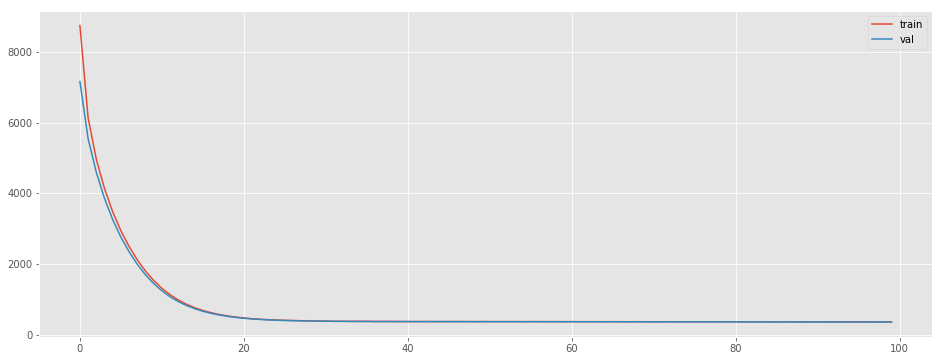

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val') 
plt.legend()  
plt.show()

## 模型评估

In [44]:
y_pred = model.predict(X_test)

In [45]:
def rmse(predictions,targets):
    return np.sqrt(((predictions-targets)**2).mean())

In [46]:
my_rmse = rmse(y_pred,y_test)

In [47]:
print("Train rmse: {}".format(np.sqrt(history.history['loss'][-1])))
print("Validation rmse: {}".format(np.sqrt(history.history['val_loss'][-1])))
print("Test rmse: {}".format(my_rmse))

Train rmse: 19.157870142395726
Validation rmse: 19.16417022078463
Test rmse: 57.22915452320545


**加入PCA降维和自动学习率下降后，精度大大提升**

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 100)               27200     
_________________________________________________________________
activation_4 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
activation_5 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total para